In [1]:
import sys
import os
proj_path = "/home/mt622/GitHubRepos/FractionalBrownianMotion"
proj_path = os.path.abspath(proj_path)
sys.path.append(proj_path)
print(sys.path)

['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/mt622/GitHubRepos/FractionalBrownianMotion/.venv/lib/python3.10/site-packages', '/home/mt622/GitHubRepos/FractionalBrownianMotion']


In [2]:


import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
from tqdm import tqdm

from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalLSTMTSPostMeanScoreMatching import \
    ConditionalLSTMTSPostMeanScoreMatching


In [30]:

# Generate value of path at time "t" by running reverse diffusion
def single_time_sampling(config, data_shape, drift_eval_diff_time, diff_time_space, diffusion, feature, scoreModel, device, prev_path):
    x = diffusion.prior_sampling(shape=data_shape).to(device)  # Move to correct device
    scores = []
    exp_scores = []
    revSDE_paths = []
    for diff_index in tqdm(range(config.max_diff_steps)):
        tau = diff_time_space[diff_index] * torch.ones((data_shape[0],)).to(device)
        try:
            scoreModel.eval()
            if diff_index == drift_eval_diff_time-1 or diff_index == drift_eval_diff_time:
                with torch.no_grad():
                    tau = tau * torch.ones((x.shape[0],)).to(device)
                    predicted_score = scoreModel.forward(x, conditioner=feature, times=tau)
            else:
                with torch.no_grad():
                    tau = tau * torch.ones((x.shape[0],)).to(device)
                    predicted_score = scoreModel.forward(x, conditioner=feature, times=tau)
        except TypeError as e:
            scoreModel.eval()
            if diff_index == drift_eval_diff_time-1 or diff_index == drift_eval_diff_time:
                with torch.no_grad():
                    tau = tau * torch.ones((x.shape[0],)).to(device)
                    eff_times = diffusion.get_eff_times(diff_times=tau)
                    eff_times = eff_times.reshape(x.shape)
                    predicted_score = scoreModel.forward(x, conditioner=feature, times=tau, eff_times=eff_times)
            else:
                with torch.no_grad():
                    tau = tau * torch.ones((x.shape[0],)).to(device)
                    eff_times = diffusion.get_eff_times(diff_times=tau)
                    eff_times = eff_times.reshape(x.shape)
                    predicted_score = scoreModel.forward(x, conditioner=feature, times=tau, eff_times=eff_times)

        score, drift, diffParam = diffusion.get_conditional_reverse_diffusion(x=x,
                                                                              predicted_score=predicted_score,
                                                                              diff_index=torch.Tensor(
                                                                                  [int(diff_index)]).to(device),
                                                                              max_diff_steps=config.max_diff_steps)
        if len(score.shape) == 3 and score.shape[-1] == 1:
            score = score.squeeze(-1)
        diffusion_mean2 = torch.atleast_2d(torch.exp(-diffusion.get_eff_times(diff_times=tau))).T.to(device)
        diffusion_var = 1. - diffusion_mean2
        exp_slope = -(1 / ((diffusion_var + diffusion_mean2 * ts_step))[0])
        exp_const = torch.sqrt(diffusion_mean2) * (ts_step) * (-config.mean_rev * prev_path.squeeze(-1))
        exp_score = exp_slope * (x.squeeze(-1) - exp_const)
        if len(exp_score) == 3 and exp_score.shape[0] == 1:
            exp_score = exp_score.squeeze(-1)
        # Store the score, the expected score, and the revSDE paths
        scores.append(score)
        exp_scores.append(exp_score)
        if len(x.shape) == 3 and x.shape[-1] == 1:
            revSDE_paths.append(x.squeeze(-1))
        else:
            assert (x.shape == (data_shape[0], 1))
            revSDE_paths.append(x)
        z = torch.randn_like(drift)
        x = drift + diffParam * z
    scores = torch.flip(torch.concat(scores, dim=-1).cpu(), dims=[1])
    exp_scores = torch.flip(torch.concat(exp_scores, dim=-1).cpu(), dims=[1])
    revSDE_paths = torch.flip(torch.concat(revSDE_paths, dim=-1).cpu(), dims=[1])
    # assert(scores.shape == (data_shape[0], config.max_diff_steps) and exp_scores.shape == (data_shape[0], config.max_diff_steps) and revSDE_paths == (data_shape[0], config.max_diff_steps))
    return x, scores, exp_scores, revSDE_paths


# In[5]:

# Generate sample paths from [0, ts_length]
def run_whole_ts_recursive_diffusion(config, drift_eval_diff_time, ts_length, initial_feature_input, diffusion, scoreModel, device,
                                     diff_time_scale, data_shape):
    stored_scores = []
    stored_expscores = []
    stored_revSDE_paths = []
    prev_paths = []
    cumsamples = initial_feature_input
    for t in (range(ts_length)):
        prev_paths.append(cumsamples.cpu())
        print("Sampling at real time {}\n".format(t + 1))
        scoreModel.eval()
        with torch.no_grad():
            if t == 0:
                feature, (h, c) = scoreModel.rnn(cumsamples, None)
            else:
                feature, (h, c) = scoreModel.rnn(cumsamples, (h, c))
        new_samples, scores, exp_scores, revSDE_paths = single_time_sampling(config=config, data_shape=data_shape, drift_eval_diff_time=drift_eval_diff_time,
                                                                             diff_time_space=diff_time_scale,
                                                                             diffusion=diffusion, scoreModel=scoreModel,
                                                                             device=device, feature=feature,
                                                                             prev_path=cumsamples)
        cumsamples = cumsamples + new_samples
        print(cumsamples.shape)
        stored_scores.append(scores.unsqueeze(1))
        stored_expscores.append(exp_scores.unsqueeze(1))
        stored_revSDE_paths.append(revSDE_paths.unsqueeze(1))
    stored_scores = torch.concat(stored_scores, dim=1)
    # assert(stored_scores.shape == (data_shape[0], T, config.max_diff_steps))
    stored_expscores = torch.concat(stored_expscores, dim=1)
    # assert(stored_expscores.shape == (data_shape[0], T, config.max_diff_steps))
    stored_revSDE_paths = torch.concat(stored_revSDE_paths, dim=1)
    # assert(stored_revSDE_paths.shape == (data_shape[0], T, config.max_diff_steps))
    prev_paths = torch.concat(prev_paths, dim=1).squeeze(-1)
    return stored_scores.cpu(), stored_expscores.cpu(), stored_revSDE_paths.cpu(), prev_paths.cpu()


# Build drift estimator
def build_drift_estimator(config, diffusion, ts_step, ts_length, diff_time_space, score_evals, Xtaus, prev_paths):
    eff_times = diffusion.get_eff_times(torch.Tensor(diff_time_space)).cpu()#.numpy()
    beta_2_taus = torch.exp(-eff_times)
    sigma_taus = 1. - beta_2_taus
    # Compute the part of the score independent of data mean
    c1 = (sigma_taus + beta_2_taus * ts_step) * torch.exp(torch.Tensor([0.5]) * eff_times)  # * 1/beta_tau
    c2 = torch.exp(torch.Tensor([0.5]) * eff_times)  # 1/beta_tau
    drift_est = c1 * score_evals + (c2.reshape(1, 1, -1)) * Xtaus
    drift_est /= ts_step
    true_drifts = (-1 * config.mean_rev * prev_paths)
    """
    for t in range(ts_length):
        # Check drifts make sense
        plt.plot(prev_paths[:, t], true_drifts[:, t])
        plt.title("True Drift Against Previous State")
        plt.show()
        plt.close()
        curr_time_mean_ests = mean_est[:, t, :]
        curr_time_true_drift = true_drifts[:, t]
        print(curr_time_mean_ests.shape, true_drifts.shape)
        # Plot MSE of drift as a function of diffusion time
        mses = np.mean(np.power(curr_time_mean_ests - curr_time_true_drift[:, np.newaxis], 2), 0)
        plt.plot(diff_time_space, mses)
        plt.title(f"Drift MSE as a function of diffusion time at real time {t + 1}")
        plt.show()
        plt.close()
        plt.plot(diff_time_space[50:400], mses[50:400])
        plt.title(f"Drift MSE as a function of diffusion time first 50 to 400 at real time {t + 1}")
        plt.show()
        plt.close()
        plt.plot(diff_time_space[7900:], mses[7900:])
        plt.title(f"Drift MSE as a function of diffusion time last 1100 at real time {t + 1}")
        plt.show()
        plt.close()
        plt.plot(diff_time_space[4000:7900], mses[4000:7900])
        plt.title(f"Drift MSE as a function of diffusion time 4000:7900 at real time {t + 1}")
        plt.show()
        plt.close()
        print(np.min(mses), np.argmin(mses))
        argmin = np.argmin(mses)
    # Choose a diffusion time for the mean estimator
    best_mean_est = mean_est[:, :, argmin]
    for t in range(ts_length):
        paired = zip(prev_paths[:, t], best_mean_est[:, t])
        sorted_pairs = sorted(paired, key=lambda x: x[0])

        # Separate the pairs back into two arrays
        currprevpath, currmeanest = zip(*sorted_pairs)
        currprevpath = np.array(currprevpath)
        currmeanest = np.array(currmeanest)
        plt.scatter(currprevpath, currmeanest, label="Sorted Estimated Drift", s=1.5)
        plt.scatter(currprevpath, -mean_rev * currprevpath, label="True Drift", s=1.5)
        plt.title(f"Est/True Drift Against State at real time {t + 1}")
        plt.show()
        plt.close()
    """
    return drift_est.cpu(), true_drifts.cpu()


def bootstrap_test_wasserstein(sample1, sample2, num_bootstrap=1000):
    # Step 1: Compute the observed Wasserstein distance
    observed_distance = wasserstein_distance(sample1, sample2)
    
    # Step 2: Bootstrap samples
    bootstrap_distances = []
    for _ in range(num_bootstrap):
        boot_sample1 = np.random.choice(sample1, size=len(sample1), replace=True)
        boot_sample2 = np.random.choice(sample2, size=len(sample2), replace=True)
        
        # Step 3: Compute Wasserstein distance for bootstrap samples
        boot_distance = wasserstein_distance(boot_sample1, boot_sample2)
        bootstrap_distances.append(boot_distance)
    
    # Step 4: Calculate p-value and confidence intervals
    bootstrap_distances = np.array(bootstrap_distances)
    p_value = np.mean(bootstrap_distances >= observed_distance)
    

    return observed_distance, p_value

In [4]:
from configs.RecursiveVPSDE.recursive_PostMeanScore_fOU_T256_H05_tl_5data import get_config as get_config_postmean
config_postmean = get_config_postmean()

rng = np.random.default_rng()
num_simulated_paths = 200
drift_eval_diff_time = int(config_postmean.max_diff_steps - 9000)
data_shape = (num_simulated_paths, 1, 1)
device = "cuda:0"

revDiff_time_scale = torch.linspace(start=config_postmean.end_diff_time, end=config_postmean.sample_eps,
                                 steps=config_postmean.max_diff_steps).to(device)
real_time_scale = torch.linspace(start=1 / config_postmean.ts_length, end=1, steps=config_postmean.ts_length).to(device)
diffusion = VPSDEDiffusion(beta_max=config_postmean.beta_max, beta_min=config_postmean.beta_min)

max_diff_steps = config_postmean.max_diff_steps
sample_eps = config_postmean.sample_eps
mean_rev = config_postmean.mean_rev
ts_step = 1 / config_postmean.ts_length

<All keys matched successfully>

In [35]:

experiments_Nepoch = {t: None for t in config_postmean.max_epochs}
for Nepoch in config_postmean.max_epochs:
    # Fix the number of training epochs and training loss objective loss
    try:
        PM = ConditionalLSTMTSPostMeanScoreMatching(*config_postmean.model_parameters).to(device)
        PM.load_state_dict(torch.load(config_postmean.scoreNet_trained_path + "_NEp" + str(Nepoch)))
        # Fix the number of real times to run diffusion
        eval_ts_length = 5
        # Experiment for score model with fixed (Nepochs, loss scaling, drift eval time, Npaths simulated)
        initial_feature_input = torch.zeros(data_shape).to(device)
        postMean_scores, postMean_expscores, postMean_revSDEpaths, postMean_prevPaths = run_whole_ts_recursive_diffusion(
            drift_eval_diff_time=drift_eval_diff_time, ts_length=eval_ts_length, config=config_postmean, initial_feature_input=initial_feature_input, diffusion=diffusion,
            scoreModel=PM, device=device, diff_time_scale=revDiff_time_scale, data_shape=data_shape)
        
        # Compute Drift Estimators
        diff_time_space = np.linspace(sample_eps, 1, max_diff_steps)
        # Output shape is (NumPaths, NumRealTimes, NumDiffSteps)
        drift_est, true_drift = build_drift_estimator(config=config_postmean,diffusion=diffusion, score_evals=postMean_scores, \
                                                      prev_paths=postMean_prevPaths, Xtaus=postMean_revSDEpaths, ts_step=ts_step, \
                                                        ts_length=eval_ts_length, diff_time_space=diff_time_space)
        
        experiments_Nepoch[Nepoch] = [drift_est, true_drift, postMean_prevPaths]
        
    except FileNotFoundError as e:
        print(f"{e}: next.")



Sampling at real time 1



100%|██████████| 10000/10000 [00:57<00:00, 174.00it/s]


torch.Size([200, 1, 1])
Sampling at real time 2



100%|██████████| 10000/10000 [00:56<00:00, 177.79it/s]


torch.Size([200, 1, 1])
Sampling at real time 3



100%|██████████| 10000/10000 [00:57<00:00, 175.30it/s]


torch.Size([200, 1, 1])
Sampling at real time 4



100%|██████████| 10000/10000 [00:57<00:00, 174.92it/s]


torch.Size([200, 1, 1])
Sampling at real time 5



100%|██████████| 10000/10000 [00:57<00:00, 175.38it/s]


torch.Size([200, 1, 1])
(torch.Size([200, 5, 10000]), torch.Size([200, 5, 10000]), torch.Size([200, 5, 10000]), torch.Size([200, 5]))
Sampling at real time 1



100%|██████████| 10000/10000 [01:03<00:00, 156.25it/s]


torch.Size([200, 1, 1])
Sampling at real time 2



100%|██████████| 10000/10000 [00:56<00:00, 175.89it/s]


torch.Size([200, 1, 1])
Sampling at real time 3



100%|██████████| 10000/10000 [00:55<00:00, 179.43it/s]


torch.Size([200, 1, 1])
Sampling at real time 4



100%|██████████| 10000/10000 [00:55<00:00, 179.37it/s]


torch.Size([200, 1, 1])
Sampling at real time 5



100%|██████████| 10000/10000 [01:02<00:00, 160.83it/s]


torch.Size([200, 1, 1])
(torch.Size([200, 5, 10000]), torch.Size([200, 5, 10000]), torch.Size([200, 5, 10000]), torch.Size([200, 5]))
Sampling at real time 1



100%|██████████| 10000/10000 [01:02<00:00, 159.26it/s]


torch.Size([200, 1, 1])
Sampling at real time 2



100%|██████████| 10000/10000 [01:02<00:00, 159.65it/s]


torch.Size([200, 1, 1])
Sampling at real time 3



100%|██████████| 10000/10000 [01:04<00:00, 154.50it/s]


torch.Size([200, 1, 1])
Sampling at real time 4



100%|██████████| 10000/10000 [01:03<00:00, 157.21it/s]


torch.Size([200, 1, 1])
Sampling at real time 5



100%|██████████| 10000/10000 [00:58<00:00, 169.77it/s]


torch.Size([200, 1, 1])
(torch.Size([200, 5, 10000]), torch.Size([200, 5, 10000]), torch.Size([200, 5, 10000]), torch.Size([200, 5]))
Sampling at real time 1



100%|██████████| 10000/10000 [00:59<00:00, 167.30it/s]


torch.Size([200, 1, 1])
Sampling at real time 2



100%|██████████| 10000/10000 [00:52<00:00, 190.33it/s]


torch.Size([200, 1, 1])
Sampling at real time 3



100%|██████████| 10000/10000 [00:52<00:00, 188.74it/s]


torch.Size([200, 1, 1])
Sampling at real time 4



100%|██████████| 10000/10000 [00:54<00:00, 185.03it/s]


torch.Size([200, 1, 1])
Sampling at real time 5



100%|██████████| 10000/10000 [00:53<00:00, 185.28it/s]


torch.Size([200, 1, 1])
(torch.Size([200, 5, 10000]), torch.Size([200, 5, 10000]), torch.Size([200, 5, 10000]), torch.Size([200, 5]))
Sampling at real time 1



100%|██████████| 10000/10000 [00:55<00:00, 179.52it/s]


torch.Size([200, 1, 1])
Sampling at real time 2



100%|██████████| 10000/10000 [00:56<00:00, 177.08it/s]


torch.Size([200, 1, 1])
Sampling at real time 3



100%|██████████| 10000/10000 [00:56<00:00, 176.41it/s]


torch.Size([200, 1, 1])
Sampling at real time 4



100%|██████████| 10000/10000 [00:56<00:00, 176.58it/s]


torch.Size([200, 1, 1])
Sampling at real time 5



100%|██████████| 10000/10000 [00:56<00:00, 178.19it/s]


torch.Size([200, 1, 1])
(torch.Size([200, 5, 10000]), torch.Size([200, 5, 10000]), torch.Size([200, 5, 10000]), torch.Size([200, 5]))
Sampling at real time 1



100%|██████████| 10000/10000 [00:56<00:00, 177.78it/s]


torch.Size([200, 1, 1])
Sampling at real time 2



100%|██████████| 10000/10000 [00:55<00:00, 180.12it/s]


torch.Size([200, 1, 1])
Sampling at real time 3



100%|██████████| 10000/10000 [00:56<00:00, 177.88it/s]


torch.Size([200, 1, 1])
Sampling at real time 4



100%|██████████| 10000/10000 [00:56<00:00, 177.89it/s]


torch.Size([200, 1, 1])
Sampling at real time 5



100%|██████████| 10000/10000 [00:57<00:00, 174.69it/s]


torch.Size([200, 1, 1])
(torch.Size([200, 5, 10000]), torch.Size([200, 5, 10000]), torch.Size([200, 5, 10000]), torch.Size([200, 5]))


In [6]:
# Fix the number of real times to run diffusion
eval_ts_length = 5
# Experiment for score model with fixed (Nepochs, loss scaling, drift eval time, Npaths simulated)
initial_feature_input = torch.zeros(data_shape).to(device)
postMean_scores, postMean_expscores, postMean_revSDEpaths, postMean_prevPaths = run_whole_ts_recursive_diffusion(
    drift_eval_diff_time=drift_eval_diff_time, ts_length=eval_ts_length, config=config_postmean, initial_feature_input=initial_feature_input, diffusion=diffusion,
    scoreModel=PM, device=device, diff_time_scale=revDiff_time_scale, real_time_scale=real_time_scale)


Sampling at real time 1



100%|██████████| 10000/10000 [00:55<00:00, 180.70it/s]


torch.Size([200, 1, 1])
Sampling at real time 2



100%|██████████| 10000/10000 [00:54<00:00, 185.08it/s]


torch.Size([200, 1, 1])
Sampling at real time 3



100%|██████████| 10000/10000 [00:52<00:00, 188.98it/s]


torch.Size([200, 1, 1])
Sampling at real time 4



100%|██████████| 10000/10000 [00:53<00:00, 186.75it/s]


torch.Size([200, 1, 1])
Sampling at real time 5



100%|██████████| 10000/10000 [00:53<00:00, 188.03it/s]


torch.Size([200, 1, 1])
(torch.Size([200, 5, 10000]), torch.Size([200, 5, 10000]), torch.Size([200, 5, 10000]), torch.Size([200, 5]))


In [7]:
diff_time_space = np.linspace(sample_eps, 1, max_diff_steps)
# Output shape is (NumPaths, NumRealTimes, NumDiffSteps)
drift_est, true_drift = build_drift_estimator(config=config_postmean,diffusion=diffusion, score_evals=postMean_scores, prev_paths=postMean_prevPaths, Xtaus=postMean_revSDEpaths, ts_step=ts_step, ts_length=eval_ts_length, diff_time_space=diff_time_space)

Bootstrapped P-Value on Wasserstein Distance: 0.506


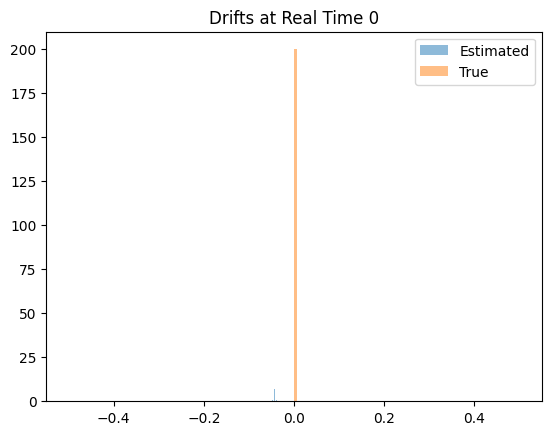

Bootstrapped P-Value on Wasserstein Distance: 0.53


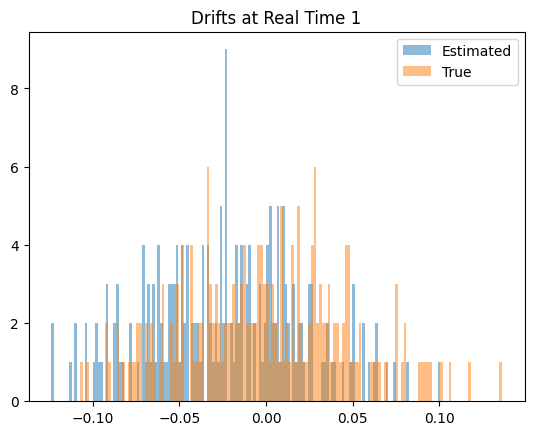

Bootstrapped P-Value on Wasserstein Distance: 0.648


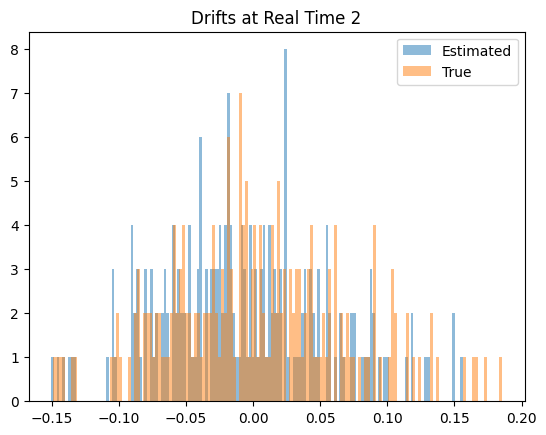

Bootstrapped P-Value on Wasserstein Distance: 0.998


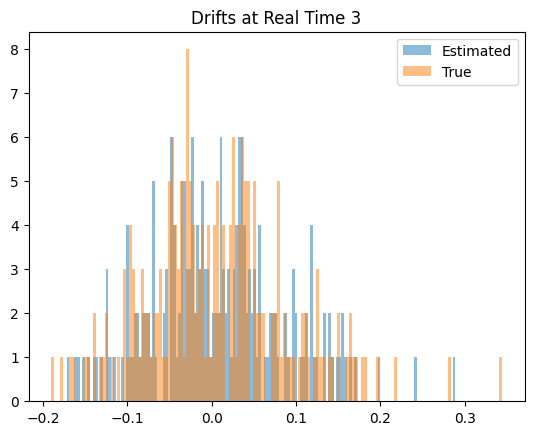

Bootstrapped P-Value on Wasserstein Distance: 0.98


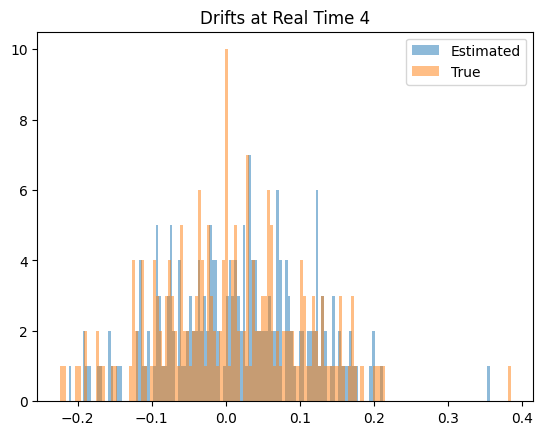

In [16]:
# Visualise distributional accuracy of estimated drifts and the true drifts
from scipy.stats import wasserstein_distance, cramervonmises_2samp, bootstrap
for t in range(eval_ts_length):
    fixed_t_drift_ests = drift_est[:, t, config_postmean.max_diff_steps - drift_eval_diff_time]
    fixed_t_drift = true_drift[:, t]
    plt.hist(fixed_t_drift_ests, bins=150, alpha=0.5, label=f"Estimated")
    plt.hist(fixed_t_drift, bins=150, alpha=0.5, label=f"True")
    print(f"Bootstrapped P-Value on Wasserstein Distance: {bootstrap_test_wasserstein(fixed_t_drift_ests, fixed_t_drift)[1]}")
    plt.title(f"Drifts at Real Time {t}")
    plt.legend()
    plt.show()
    plt.close()

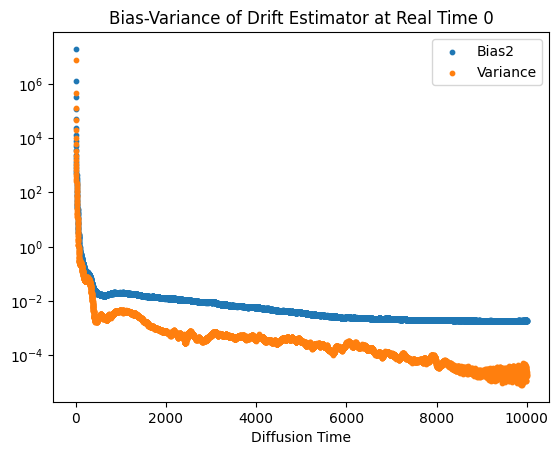

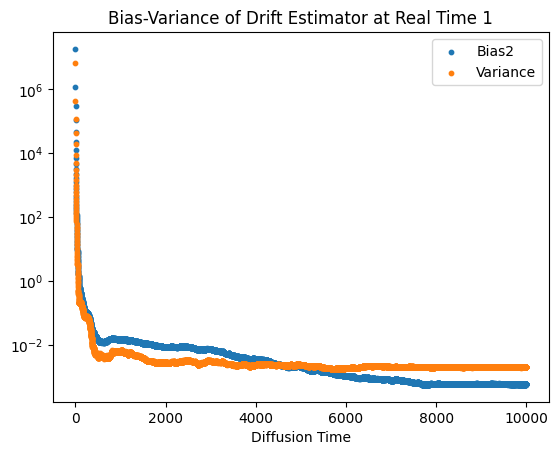

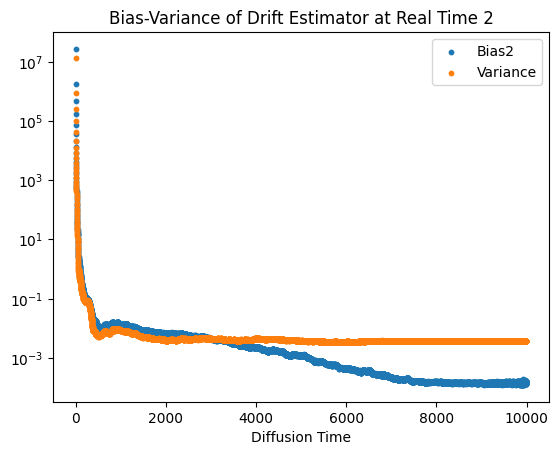

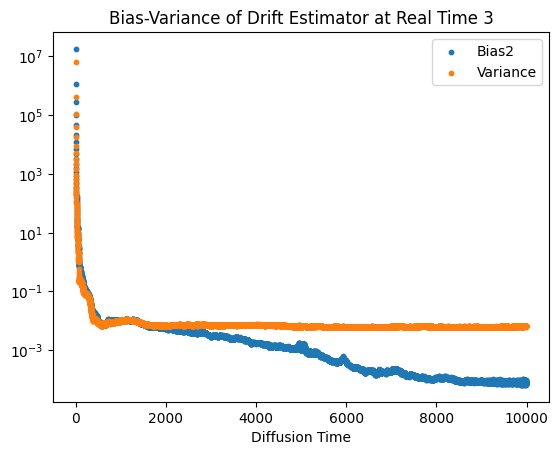

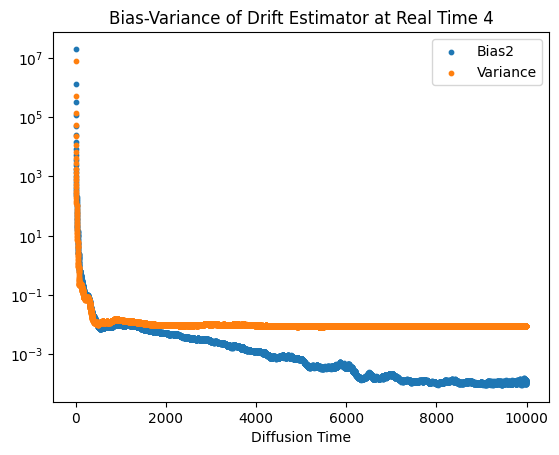

In [18]:
# Compute mean and bias2 for the drift estimates across different diffusion times
bias2 = torch.pow(true_drift.unsqueeze(-1) - drift_est,2).mean(axis=0)
variance = torch.var(drift_est, axis=0)
for t in range(eval_ts_length):
    plt.scatter(np.arange(config_postmean.max_diff_steps), bias2[t, :], s=10, label="Bias2")
    plt.scatter(np.arange(config_postmean.max_diff_steps), variance[t, :], s=10, label="Variance")
    plt.title(f"Bias-Variance of Drift Estimator at Real Time {t}")
    plt.xlabel("Diffusion Time")
    plt.legend()
    plt.yscale("log")
    plt.show()
    plt.close()

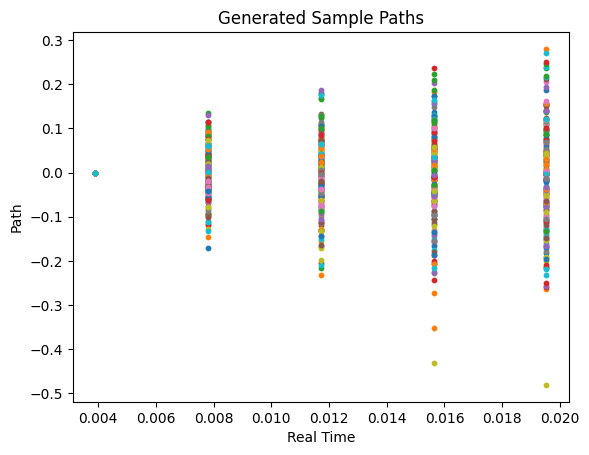

In [29]:
# Plot the drift estimator for different sample paths across time
for pathid in range(num_simulated_paths):
    plt.scatter(real_time_scale[:eval_ts_length].cpu(), postMean_prevPaths[pathid,:].cpu(), s=10)
plt.xlabel("Real Time")
plt.ylabel("Path")
plt.title("Generated Sample Paths")
plt.show()
plt.close()

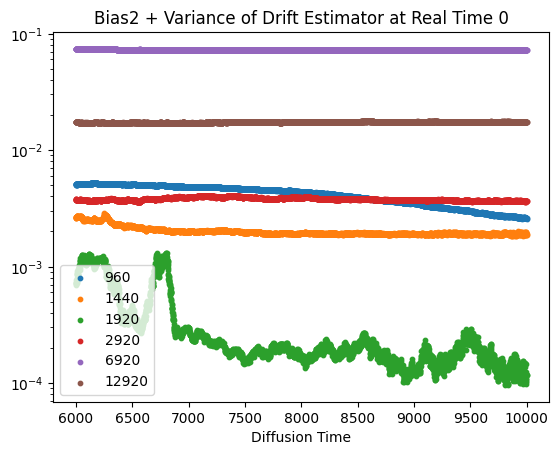

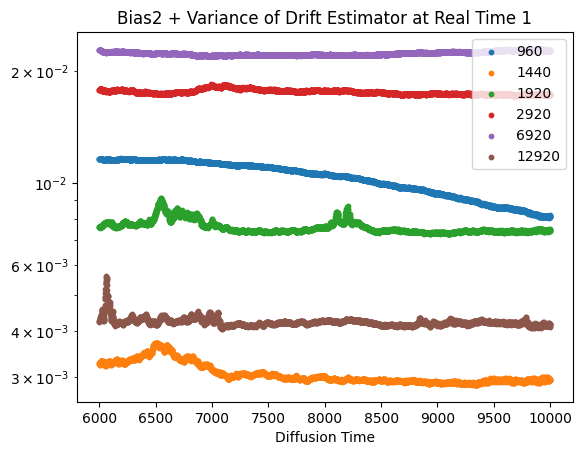

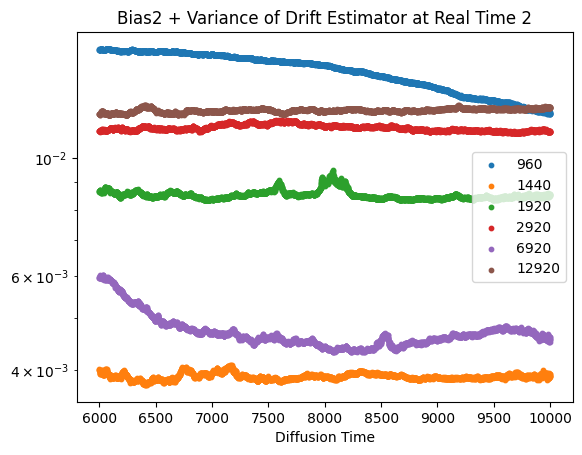

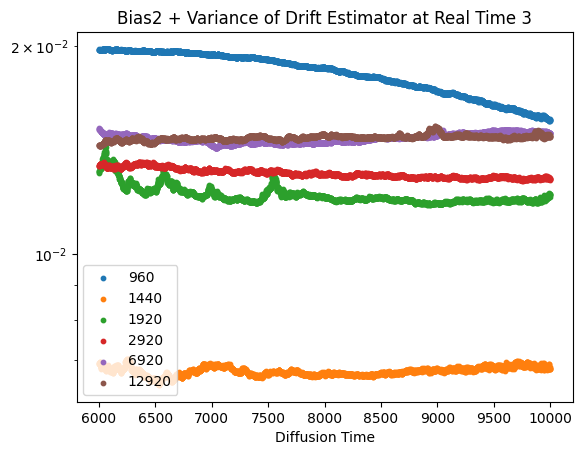

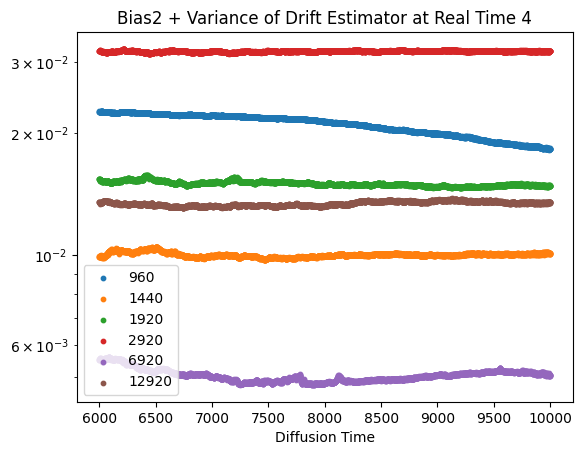

In [37]:
# Compute bias2 + variance for same real times for different training epochs
experiment_emses = {t: None for t in config_postmean.max_epochs}
for key, values in experiments_Nepoch.items():
    drift_est, true_drift, _ = values
    bias2 = torch.pow(true_drift.unsqueeze(-1) - drift_est,2).mean(axis=0)
    variance = torch.var(drift_est, axis=0)
    emse = bias2 + variance
    experiment_emses[key] = emse

for t in range(eval_ts_length):
    for key, values in experiment_emses.items():
        plt.scatter(np.arange(6000,config_postmean.max_diff_steps), values[t, 6000:], s=10, label=f"{key}")
        plt.title(f"Bias2 + Variance of Drift Estimator at Real Time {t}")
    plt.legend()
    plt.xlabel("Diffusion Time")
    plt.yscale("log")
    plt.show()
    plt.close()